# Imports

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import fitz as fitz
import re as re
from enum import Enum
import io as io

## Classes and Enums

In [45]:
# using as a value tracker

class RoomOrder(Enum):
	ABF = 0 # 18a, 18b, 18
	BAF = 1 # 18b, 18a, 18
	AFB = 2 # 18a, 18, 18b
	BFA = 3 # 18b, 18, 18a
	FAB = 4 # 18, 18a, 18b
	FBA = 5 # 18, 18b, 18a
	BA = 6 # 18b, 18a
	BF = 7 # 18b, 18
	FB = 8 # 18, 18b
	FA = 9 # 18, 18a
	AB = 10 # 18a, 18b
	AF = 11 # 18a, 18
	A = 12 # 18a
	B = 13 # 18b
	F = 14 # 18

class GroupComp(Enum):
	INDIVIDUAL = 0
	GROUP = 1

class LecternsViewed(Enum):
	N = "None"
	W = "West"
	M = "Middle"
	E = "East"
	WM = "West, Middle"
	WE = "West, East"
	ME = "Middle, East"
	WME = "West, Middle, East"

class VisitorType(Enum):
	BROWSER = 0
	FOLLOWER = 1
	SEARCHER = 2
	RESEARCHER = 3

class TurnDirection(Enum):
	LEFT = 0
	MIDDLE = 1
	RIGHT = 2
	NONE = 3

class TeamMember(Enum):
	Courtney = 0
	Jerry = 1
	Owen = 2
	Ritvik = 3
	Sofia = 4

class Gender(Enum):
	FEMALE = 0
	MALE = 1

class FirstTurnDirection(Enum):
	LEFT = 0
	MIDDLE = 1
	RIGHT = 2

class DayOfWeek(Enum):
	Sunday = 0
	Monday = 1
	Tuesday = 2
	Wednesday = 3
	Thursday = 4
	Friday = 5
	Saturday = 6

# Code

## Constants

In [46]:
# TODO: update all values accordingly
# relative file paths
visitor_xlsx_path: str = "../../assets/excel_files/observation_tables.xlsx"
survey_xlsx_path: str = "../../assets/excel_files/survey_responses.xlsx"

# sheet names
main_sheet_name: str = "main data"
groups_sheet_name_base: str = "object group"

# export paths
observation_export_path: str = "../../assets/output_files/visitor_box_plots.pdf"
observation_metadata_export_path: str = "../../assets/metadata_output/visitor_box_plots_metadata.pdf"
group_export_path: str = "../../assets/output_files/group_box_plots.pdf"
group_metadata_export_path: str = "../../assets/metadata_output/group_box_plots_metadata.pdf"
survey_export_path: str = "../../assets/output_files/survey_box_plots.pdf"
survey_metadata_export_path: str = "../../assets/metadata_output/survey_box_plots_metadata.pdf"

## Loading XLSX

In [47]:
visitor_xlsx: pd.ExcelFile = pd.ExcelFile(visitor_xlsx_path)
visitor_df: pd.DataFrame = pd.read_excel(visitor_xlsx, sheet_name=main_sheet_name, index_col=0)

groups_df: pd.DataFrame = pd.DataFrame()
for i in visitor_df["visitor_id"].values:
	sheet_name: str = groups_sheet_name_base + " " + "{0:0=3d}".format(i)
	temp_df: pd.DataFrame = pd.read_excel(visitor_xlsx, sheet_name=sheet_name, index_col=0)
	col_name: str = "{0:0=3d}".format(i) + "_" + "dwell_time"
	groups_df[col_name] = temp_df["dwell_time"]
groups_df = groups_df.T

survey_xlsx: pd.ExcelFile = pd.ExcelFile(survey_xlsx_path)
survey_df: pd.DataFrame = pd.read_excel(survey_xlsx, index_col=8)
# isolate row of question names
survey_question_names: pd.Series = survey_df.iloc[0]
# remove row of question names
survey_df = survey_df[1:]

In [48]:
# formatting question names and extracting field names
regex: re.Pattern = re.compile(r"^(.+?): - ([^:]+):(.+)$")
survey_question_data: dict[str, tuple[str, str, str]] = {}

for i in survey_question_names.keys():
	match = regex.match(survey_question_names[i])
	if match:
		survey_question_data[i] = (match.group(1), match.group(2), match.group(3))

## Operations

### Support Functions

In [49]:
# lists of columns to analyze and snums to transform labels
OBSERVATION_ANALYSIS_COLS: list[str] = [
	"total_time",
]

OBSERVATION_ENUM_CLASSES: list[Enum] = []

GROUP_ANALYSIS_COLS: list[str] = [
	"South Metopes II-V",
	"West Pediments",
	"South Metopes VI-IX",
	"South Metopes XXVI-XXIX",
	"East Pediments",
	"South Metopes XXX-XXXII",
	"Frieze Section 1",
	"Frieze Section 2",
	"Frieze Section 3",
	"Frieze Section 4",
	"Frieze Section 5"
]

GROUP_ENUM_CLASSES: list[Enum] = []

SURVEY_ANALYSIS_COLS: list[str] = [
	"Q15_1",
	"Q15_2",
	"Q15_3",
	"Q21_1",
	"Q21_2",
	"Q21_3",
	"Q21_4",
	"Q21_5",
	"Q22_1",
	"Q23_1"
]

SURVEY_ENUM_CLASSES: list[Enum] = []

In [50]:
def plot_data(df: pd.DataFrame, analysis_cols: list, enum_classes: list, names: dict, label: str, export_path: str, metadata_export_path: str, show_plots: bool) -> None:
	"""
	Generates boxplots for specified columns and saves them to a PDF.

	Creates horizontal boxplots for numerical data, excluding zero values and 
	NaNs. Plots are arranged two per page (top and bottom) in the resulting
	PDF document.

	Args:
		df: The pandas DataFrame containing the data to analyze.
		analysis_cols: List of column names to generate plots for.
		enum_classes: List of Enum classes (unused in this function version, 
					  kept for signature compatibility).
		names: A dictionary mapping column names to lists containing title 
			   components [line1, line2, subtitle].
		label: The label for the x-axis (e.g., unit of measurement).
		export_path: File path where the resulting PDF will be saved.
		show_plots: If True, displays each plot in the current environment.
	"""
	doc: fitz.Document = fitz.open()

	given_names: bool = names is not None

	page_width: int = 595
	page_height: int = 842

	margin: int = 50
	midpoint: int = page_height / 2

	master_map: dict[str, str] = {}
	for enum_cls in enum_classes:
		for member in enum_cls:
			master_map[member.name] = str(member.value)

	plot_df: pd.DataFrame = df.copy()

	metadata_text: str = ""

	for i, col in enumerate(analysis_cols):
		if i % 2 == 0:
			page: fitz.Page = doc.new_page(width=page_width, height=page_height)
		
		fig: plt.Figure
		ax: plt.Axes
		fig, ax = plt.subplots(figsize=(8, 5))

		df[col] = pd.to_numeric(df[col], errors='coerce')
		cleaned_data = df[(df[col] != 0) & (df[col].notna())][col]
		plt.boxplot(cleaned_data, vert=False)

		if given_names:
			plt.title(names[col][0] + "\n" + names[col][1] + " --- " + names[col][2])
		else:
			plt.title(col)
		
		summary = cleaned_data.describe(percentiles=[.25, .5, .75])
		q1 = round(summary['25%'], 3)
		q3 = round(summary['75%'], 3)
		iqr = q3 - q1
		metadata_text += col + ":\n"
		metadata_text += "Min: " + str(round(summary['min'], 3)) + ", Q1: " + str(q1) + ", Median: " + str(round(summary['50%'], 3)) + ", Q3: " + str(q3) + ", Max: " + str(round(summary['max'], 3)) + ", IQR: " + str(iqr) + "\n\n"

		plt.xticks(rotation=45)
		plt.xlabel(label)
		plt.yticks([])
		plt.subplots_adjust(bottom=0.2, top=0.9)
		image_data: io.BytesIO = io.BytesIO()
		fig.savefig(image_data, format="png", dpi=150)
		if show_plots:
			plt.show(fig)
		image_data.seek(0)

		image_rect: fitz.Rect
		text_y: int
		if i % 2 == 0:
			image_rect = fitz.Rect(margin, margin, page_width - margin, midpoint - 40)
			text_y = midpoint - 20
		else:
			image_rect = fitz.Rect(margin, midpoint + 20, page_width - margin, page_height - margin - 40)
			text_y = page_height - 30
		
		page.insert_image(image_rect, stream=image_data.read())

		page.insert_text((margin, text_y), "Analysis for column '" + col + "'", fontsize=12)
		plt.close(fig)
	doc.save(export_path)
	doc.close()

	metadata_doc: fitz.Document = fitz.open()
	metadata_page: fitz.Page = metadata_doc.new_page()
	metadata_page.insert_text(
		fitz.Point(50, 50),
		metadata_text,
		fontsize=12
	)
	metadata_doc.save(metadata_export_path)
	metadata_doc.close()

In [51]:
# # TODO: graph 18a and 18b box plots on one graph, survey data

# def plot_group_data(df: pd.DataFrame, analysis_cols: list, enum_classes: list, names: dict, label: str | list[str], export_path: str, metadata_export_path: str, show_plots: bool) -> None:
	
# 	doc: fitz.Document = fitz.open()

# 	given_names: bool = names is not None

# 	page_width: int = 595
# 	page_height: int = 842

# 	margin: int = 50
# 	midpoint: int = page_height / 2

# 	master_map: dict[str, str] = {}
# 	for enum_cls in enum_classes:
# 		for member in enum_cls:
# 			master_map[member.name] = str(member.value)

# 	plot_df: pd.DataFrame = df.copy()

# 	for i, col in enumerate(analysis_cols):
# 		if i % 2 == 0:
# 			page: fitz.Page = doc.new_page(width=page_width, height=page_height)
		
# 		fig: plt.Figure
# 		ax: plt.Axes
# 		fig, ax = plt.subplots(figsize=(8, 5))

# 		df[col] = pd.to_numeric(df[col], errors='coerce')
# 		plt.boxplot(df[(df[col] != 0) & (df[col].notna())][col], vert=False)

# 		if given_names:
# 			plt.title(names[col][0] + "\n" + names[col][1] + " --- " + names[col][2])
# 		else:
# 			plt.title(col)

# 		plt.xticks(rotation=45)
# 		if type(label) == str:
# 			plt.xlabel(label)
# 		elif len(label) == len(analysis_cols):
# 			plt.xlabel(label[i])
# 		elif len(label) > len(analysis_cols):
# 			raise Exception("Too many labels given")
# 		else:
# 			raise Exception("Too few labels given")
# 		plt.yticks([])
# 		plt.subplots_adjust(bottom=0.2, top=0.9)
# 		image_data: io.BytesIO = io.BytesIO()
# 		fig.savefig(image_data, format="png", dpi=150)
# 		if show_plots:
# 			plt.show(fig)
# 		image_data.seek(0)

# 		image_rect: fitz.Rect
# 		text_y: int
# 		if i % 2 == 0:
# 			image_rect = fitz.Rect(margin, margin, page_width - margin, midpoint - 40)
# 			text_y = midpoint - 20
# 		else:
# 			image_rect = fitz.Rect(margin, midpoint + 20, page_width - margin, page_height - margin - 40)
# 			text_y = page_height - 30
		
# 		page.insert_image(image_rect, stream=image_data.read())

# 		page.insert_text((margin, text_y), "Analysis for column '" + col + "'", fontsize=12)
# 		plt.close(fig)
# 	doc.save(export_path)
# 	doc.close()

# 	metadata_doc: fitz.Document = fitz.open()
# 	metadata_page: fitz.Page = metadata_doc.new_page()
# 	metadata_page.insert_text(
# 		fitz.Point(50, 50),
# 		metadata_text,
# 		fontsize=12
# 	)
# 	metadata_doc.save(metadata_export_path)
# 	metadata_doc.close()

### Execution

In [52]:
plot_data(visitor_df, OBSERVATION_ANALYSIS_COLS, OBSERVATION_ENUM_CLASSES, None, "Time (min)", observation_export_path, observation_metadata_export_path, False)

count    100.000000
mean       9.300000
std       10.254834
min        1.000000
25%        4.000000
50%        7.000000
75%       11.000000
max       68.000000
Name: total_time, dtype: float64


count     24.000000
mean      43.291667
std       37.147742
min        8.000000
25%       20.000000
50%       28.500000
75%       51.500000
max      140.000000
Name: South Metopes II-V, dtype: float64


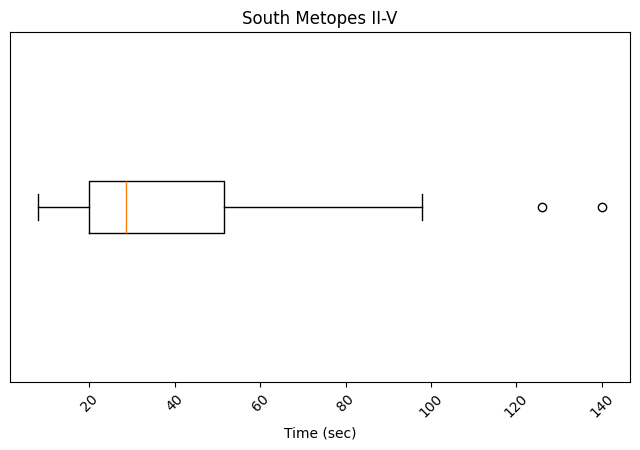

count     61.000000
mean      61.524590
std       52.422198
min        3.000000
25%       24.000000
50%       47.000000
75%       75.000000
max      232.000000
Name: West Pediments, dtype: float64


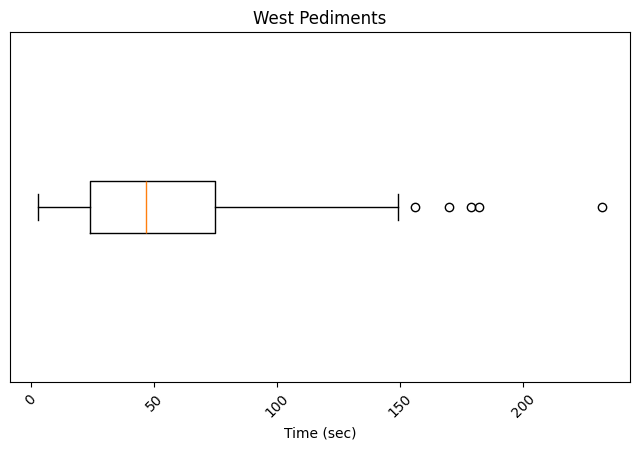

count     21.000000
mean      29.142857
std       36.786255
min        1.000000
25%        7.000000
50%       12.000000
75%       30.000000
max      127.000000
Name: South Metopes VI-IX, dtype: float64


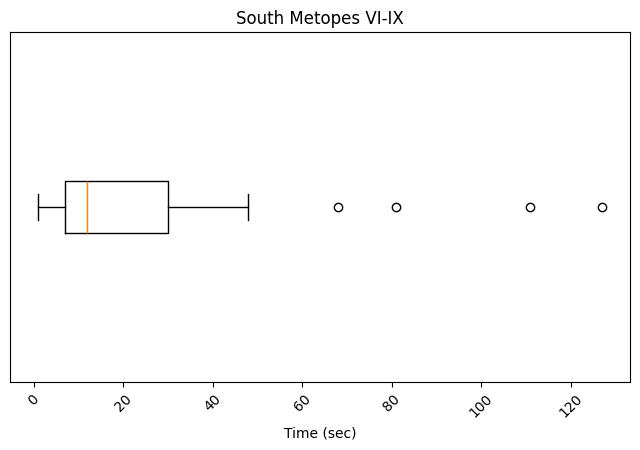

count     20.00000
mean      61.30000
std       60.36564
min        4.00000
25%       15.75000
50%       35.50000
75%       96.25000
max      217.00000
Name: South Metopes XXVI-XXIX, dtype: float64


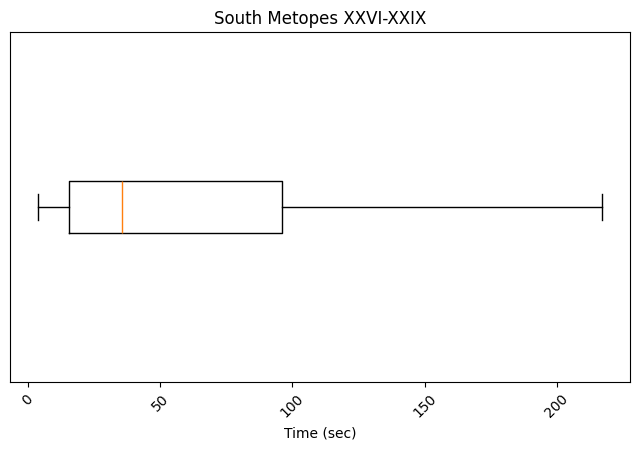

count      77.000000
mean       95.311688
std       161.553011
min         3.000000
25%        23.000000
50%        51.000000
75%       114.000000
max      1335.000000
Name: East Pediments, dtype: float64


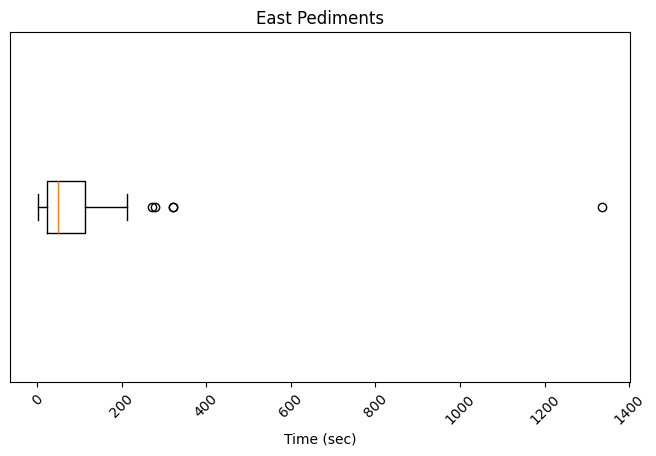

count     28.000000
mean      30.178571
std       28.433227
min        1.000000
25%        8.750000
50%       24.500000
75%       38.250000
max      128.000000
Name: South Metopes XXX-XXXII, dtype: float64


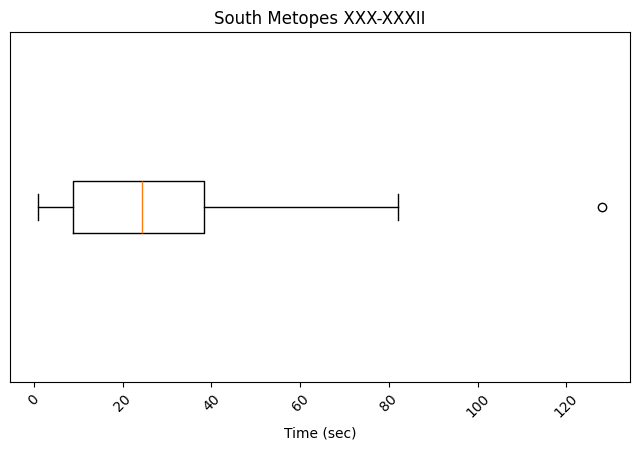

count     24.000000
mean      43.166667
std       49.208224
min        1.000000
25%        7.000000
50%       31.000000
75%       67.750000
max      195.000000
Name: Frieze Section 1, dtype: float64


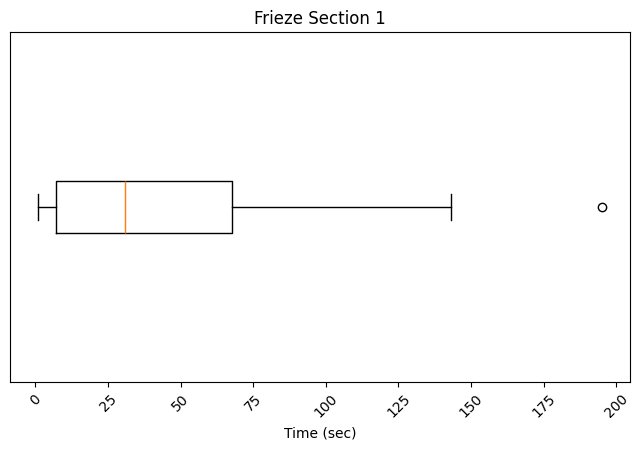

count     30.000000
mean      37.333333
std       71.386917
min        3.000000
25%        6.500000
50%       15.000000
75%       35.750000
max      382.000000
Name: Frieze Section 2, dtype: float64


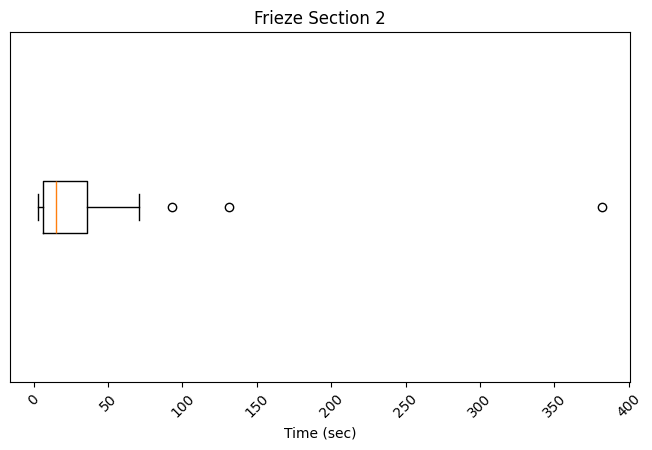

count     30.000000
mean      32.300000
std       47.677183
min        3.000000
25%        9.000000
50%       16.500000
75%       33.000000
max      244.000000
Name: Frieze Section 3, dtype: float64


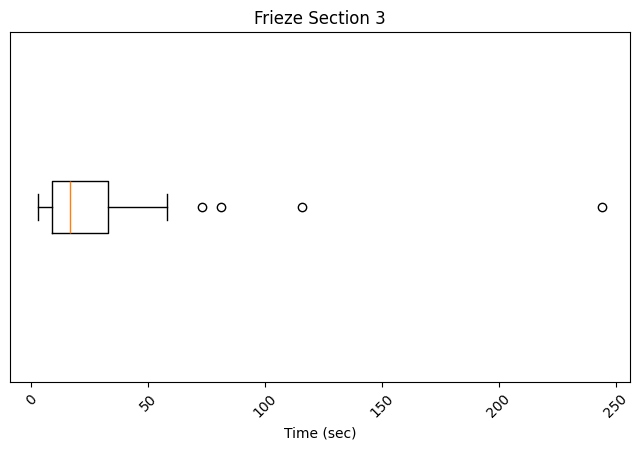

count     27.000000
mean      35.518519
std       46.068820
min        1.000000
25%        5.500000
50%       23.000000
75%       35.000000
max      187.000000
Name: Frieze Section 4, dtype: float64


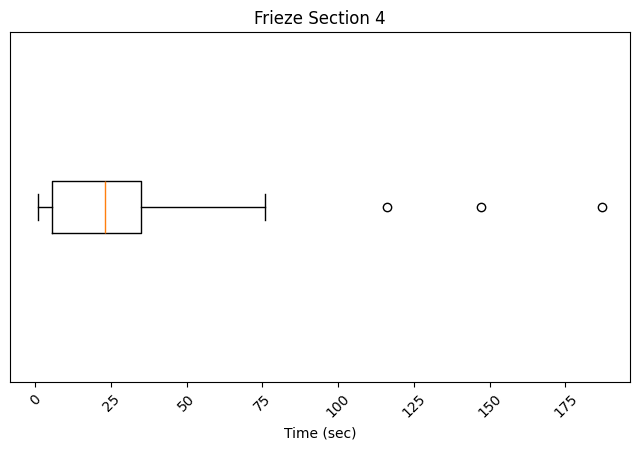

count     37.000000
mean      38.432432
std       57.148219
min        3.000000
25%        9.000000
50%       21.000000
75%       48.000000
max      306.000000
Name: Frieze Section 5, dtype: float64


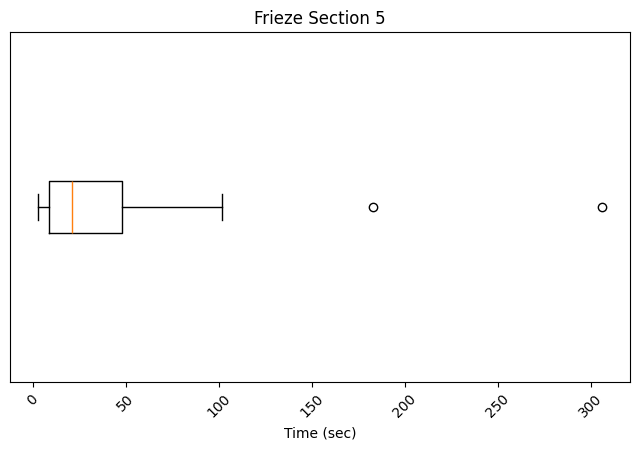

In [53]:
plot_data(groups_df, GROUP_ANALYSIS_COLS, GROUP_ENUM_CLASSES, None, "Time (sec)", group_export_path, group_metadata_export_path, True)

In [54]:
plot_data(survey_df, SURVEY_ANALYSIS_COLS, SURVEY_ENUM_CLASSES, survey_question_data, "Responses", survey_export_path, survey_metadata_export_path, False)

count    3.000000
mean     3.666667
std      0.577350
min      3.000000
25%      3.500000
50%      4.000000
75%      4.000000
max      4.000000
Name: Q15_1, dtype: float64
count    3.0
mean     3.0
std      0.0
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: Q15_2, dtype: float64
count    3.0
mean     3.0
std      1.0
min      2.0
25%      2.5
50%      3.0
75%      3.5
max      4.0
Name: Q15_3, dtype: float64
count    83.000000
mean      4.168675
std       0.793561
min       2.000000
25%       4.000000
50%       4.000000
75%       5.000000
max       5.000000
Name: Q21_1, dtype: float64
count    82.000000
mean      4.073171
std       1.086170
min       1.000000
25%       3.250000
50%       4.000000
75%       5.000000
max       5.000000
Name: Q21_2, dtype: float64
count    82.000000
mean      4.012195
std       0.895722
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000
Name: Q21_3, dtype: float64
count    81.000000
mean 